In [ ]:
import random,math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from contextlib import contextmanager
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

#from n_framework import *
from n_framework_copy import *

from fastprogress import progress_bar,master_bar

In [ ]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder

import logging
from fastcore.test import test_close

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
logging.disable(logging.WARNING)

## Learner

In [ ]:
x,y = 'image','label'
name = 'fashion_mnist'
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b): b[x]=[torch.flatten(TF.to_tensor(o))for o in b[x]]

In [ ]:
bs=1024
tds = dsd.with_transform(transformi)

In [ ]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [ ]:
#|export
class DataLoaders:
    def __init__(self,*dls): self.train,self.valid = dls[:2]
    @classmethod
    def from_dd(cls,dd,batch_size, as_tuple=True):
        #return cls(*[DataLoader(ds, batch_size,num_workers=4, collate_fn=collate_dict(ds)) for ds in dd.values()])
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds)) for ds in dd.values()])

In [ ]:
dls = DataLoaders.from_dd(tds,bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [ ]:
m,nh =28*28,50
model = nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10))

In [ ]:
#When the num_workers=0/4/8 the time it took largely changes 
learn = Learner(model,dls, F.cross_entropy, lr=0.2)
%time learn.fit(1)

0 True 1.18521953125 0.59565
0 False 1.1349697544642856 0.6088142857142858
CPU times: user 8.95 s, sys: 251 ms, total: 9.2 s
Wall time: 9.91 s


## Basic Callback Learner

In [ ]:
#|export
def identity(*args):
    #import pdb;pdb.set_trace()
    if not args:return
    x,*args = args
    return (x,)+tuple(args) if args else x

In [ ]:
identity(3,'4',1)

(3, '4', 1)

In [ ]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [ ]:
#| export
def run_cbs(cbs,method_nm,learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None:method()

In [ ]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [ ]:
#|export 
class callback(): order=0

In [ ]:
class CompletionCallback(callback):
    def before_fit(self): self.count= 0
    def after_batch(self): self.count += 1
    def after_fit(self): print(f'Completed {self.count} batches')

In [ ]:
cbs = [CompletionCallback()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [ ]:
cb = cbs[0];cb

<__main__.CompletionCallback>

In [ ]:
getattr(cb, 'after_fit', None)()

Completed 1 batches


In [ ]:
#|export
class with_cbs:
    def __init__(self,nm): self.nm = nm
    def __call__(self, f):
        def _f(o,*args,**kwargs):
            try:
                o.callback(f"before_{self.nm}")
                f(o,*args,**kwargs)
                o.callback(f"After_{self.nm}")
            except globals()[f'Cancel{self.nm.title()}Exception']:pass
        return _f

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs,opt_func=optim.SGD): 
        fc.store_attr()
        for cb in cbs: cb.learn = self

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.training = train
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')            
            for self.iter,self.batch in enumerate(self.dl): 
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException:pass
            self.callback('after_epoch')
        except CancelEpochException:pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException:pass

    def callback(self,method_nm): run_cbs(self.cbs,method_nm,self)

In [ ]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
class SingleCallback(callback):
    order =1
    def after_batch(self): raise CancelEpochException()

In [ ]:
learn = Learner(get_model(),dls, F.cross_entropy, lr=0.2, cbs=[SingleCallback(),CompletionCallback()])
%time learn.fit(1)

Completed 2 batches
CPU times: user 247 ms, sys: 12.2 ms, total: 259 ms
Wall time: 263 ms


In [ ]:
#| export
class DeviceCb(callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self): self.learn.model.to(self.device)
    def before_batch(self): self.learn.batch = to_device(self.learn.batch,device=self.device)

In [ ]:
class DeviceCB(callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

## Metric

In [ ]:

class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals, self.ns = [],[]
    def add(self,inp, targ=None, n=1): # n is the number of items in the mini-batch.
        self.last = self.calc(inp,targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps,targs): return inps 

In [ ]:

class Accuracy(Metric):
    def calc(self,inps,targs): return (inps==targs).float().mean()

In [ ]:
acc = Accuracy()
acc.add(tensor([0,1,2,0,1,2]),tensor([0,1,1,2,1,0]))
acc.add(tensor([1,1,2,0,1]),tensor([0,1,1,2,1]))
acc.value

tensor(0.45)

In [ ]:
loss=Metric()
loss.add(0.6,n=32)
loss.add(0.9,n=2)
loss.value,round((0.6*32+0.9*2)/(32+2),2)

(tensor(0.62), 0.62)

In [ ]:
#| export
from torcheval.metrics import MulticlassAccuracy,Mean

In [ ]:
metric = MulticlassAccuracy()
metric.update(tensor([0,2,1,3]), tensor([0,1,2,3]))
metric.compute()

tensor(0.50)

In [ ]:
metric.reset()
metric.compute()

tensor(nan)

In [ ]:
#| export
def to_cpu(x):
    if isinstance(x,Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x,list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [ ]:
#| export
class MetricsCb(callback):
    def __init__(self, *ms, **metrics):
        for o in ms:metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    def _log(self,d): print(d)
    def before_fit(self): self.learn.metrics = self
    def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
    def after_epoch(self):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = self.learn.epoch
        log['train'] = self.learn.model.training
        self._log(log)
    
    def after_batch(self):
        x,y = to_cpu(self.learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(self.learn.preds),y)
        self.loss.update(to_cpu(self.learn.loss),weight=len(x))

In [ ]:
#|export
class MetricsCB(callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
model = get_model()
metrics = MetricsCb(accuracy=MulticlassAccuracy())
learn = Learner(model,dls,F.cross_entropy, lr=0.2, cbs=[DeviceCb(),metrics])
learn.fit(1)

{'accuracy': '0.621', 'loss': '1.147', 'epoch': 0, 'train': True}
{'accuracy': '0.685', 'loss': '0.824', 'epoch': 0, 'train': False}


In [ ]:
model = get_model()
metrics = MetricsCb(MulticlassAccuracy())
learn = Learner(model,dls,F.cross_entropy, lr=0.2, cbs=[DeviceCb(),metrics])
learn.fit(1)

{'MulticlassAccuracy': '0.628', 'loss': '1.142', 'epoch': 0, 'train': True}
{'MulticlassAccuracy': '0.674', 'loss': '0.889', 'epoch': 0, 'train': False}


### Flexible Learner

In [ ]:
# this learner has errors
class Learner():
    def __init__(self,model,dls,loss_func,lr,cbs, opt_func= optim.SGD):
        fc.store_attr()
        for cb in cbs: cb.learn =self
     
    @contextmanager
    def callback_ctx(self,nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        #except globals()[f'Cancel{nm.title()}Exception']:pass
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
    
    def one_epoch(self,train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.callback_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                 with self.callback_ctx('batch'):
                        self.predict()
                        self.get_loss()
                        if self.model.training:
                            self.backward()
                            self.step()
                            self.zero_grad()
                 
    def fit(self,n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(),self.lr)
        with self.callback_ctx('fit'):
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
    
    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self,method_nm): run_cbs(self.cbs,method_nm)

In [ ]:
#| export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [ ]:
#|export
class TrainCB(callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
#|export
class ProgressCb(callback):
    order = MetricsCB.order+1
    def __init__(self,plot=False): self.plot = plot
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn,'metrics'): self.learn.metrics._log = self._log
        self.losses = []
    def _log(self,d): self.mbar.write(d)
    def before_epoch(self): self.learn.dl = progress_bar(self.learn.dl,leave =False, parent=self.mbar)
    def after_batch(self):
        self.learn.dl.comment = f'{self.learn.loss:.3f}'
        if self.plot and hasattr(self.learn,'metrics') and self.learn.model.training:
            self.losses.append(self.learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses),self.losses]])

In [ ]:
#|export
class ProgressCB(callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

In [ ]:
model = get_model()

accuracy,loss,epoch,train
0.601,1.197,0,train
0.714,0.785,0,eval
0.745,0.714,1,train
0.760,0.688,1,eval


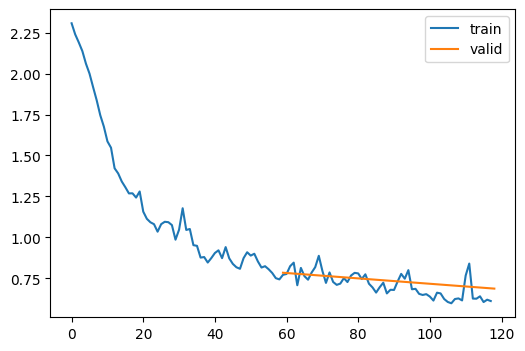

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

## Subclass Train Learner

In [ ]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [ ]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self,model,dls,loss_func,lr,cbs, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model,dls,loss_func,lr,cbs, opt_func)
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.694,0.894,0,train
0.803,0.546,0,eval


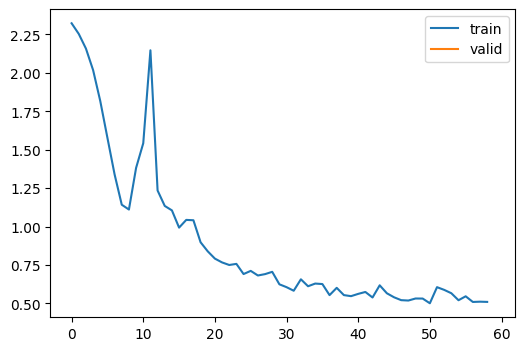

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(),metrics,ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls,F.cross_entropy,lr=0.2,cbs=cbs)
learn.fit(1)

### LearningRateFinderCB

In [ ]:
class LRFinderCB(callback):
    def __init__(self,lr_mul=1.3): fc.store_attr()
        
    def before_fit(self,learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf
    
    def after_batch(self,learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *=self.lr_mul
    
    def plot(self):
        plt.plot(self.lrs,self.losses)
        plt.xscale('log')

In [ ]:
lrfind = LRFinderCB()
cbs = [DeviceCB(),ProgressCB(),lrfind]
learn = MomentumLearner(get_model(),dls,F.cross_entropy,lr=1e-3,cbs=cbs)
learn.fit(1)

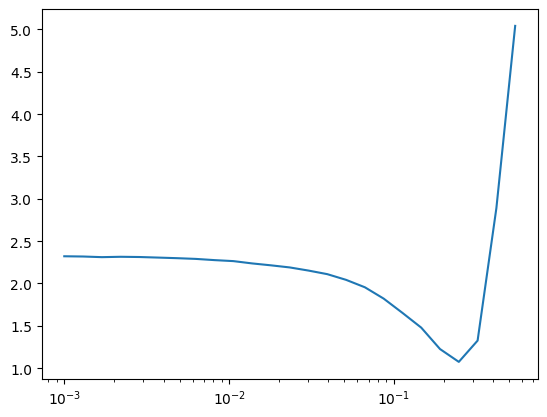

In [ ]:
lrfind.plot()

In [ ]:
#| export 
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
#|export
class LRFinderCB(callback):
    def __init__(self,gamma=1.3): fc.store_attr()
        
    def before_fit(self,learn):
        self.sched = ExponentialLR(learn.opt,self.gamma) 
        self.lrs,self.losses = [],[]
        self.min = math.inf
    
    def after_batch(self,learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        self.sched.step()
        
    def cleanup_fit(self,learn):
        plt.plot(self.lrs,self.losses)
        plt.xscale('log')

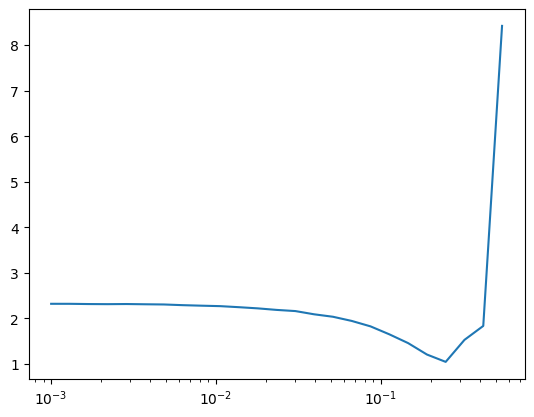

In [ ]:
lrfind = LRFinderCB()
cbs = [DeviceCB(),ProgressCB(),lrfind]
learn = MomentumLearner(get_model(),dls,F.cross_entropy,lr=1e-3,cbs=cbs)
learn.fit(1)